# Noise Simulation Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import qsttoolkit as qst

## Noise Sources

Quantum state noise is described as *state preparation and measurement* (SPAM) noise. Noise sources for optical quantum states simulated by QSTToolkit divide this definition into three categories:
- State preparation noise, arising from imperfect preparation and preservation of the state.
- Measurement noise, due to the quantum mechanical process of measurement and the specific measurement regime in use.
- Data noise, from incorrect data collection and processing.

Note that the levels of noise sources applied in this notebook are exaggerated to demonstrate their effect on measurement data.

First, we prepare a test coherent state:

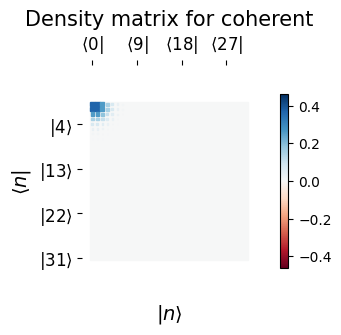

In [2]:
dim = 32                                # Hilbert space dimensionality
test_state = qt.coherent_dm(dim, 1.0)

qst.plot_hinton(test_state, label='coherent')
plt.show()

### State preparation noise

Thermal mixing of the state with its environment is simulated by a weighted mixing of the pure state with a random mixed state:

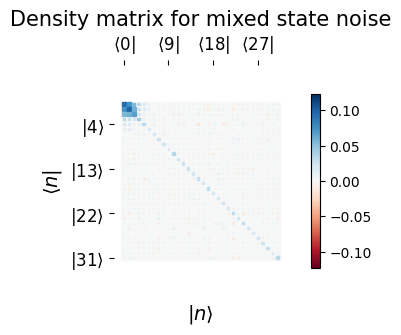

In [3]:
ms_noise = qst.data.mixed_state_noise(test_state, noise_level=0.8)

qst.plot_hinton(ms_noise, label='mixed state noise')
plt.show()

A lossy resonator is simulated by evolving the state for a short time using the Lindblad master equation:

c:\Users\gwfit\OneDrive\Documents\Durham University Physics\Level 4\MPhys Project - Deep Learning Quantum Tomography\Code\qsttoolkit-private\venv\Lib\site-packages\scipy\integrate\_ode.py:431: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


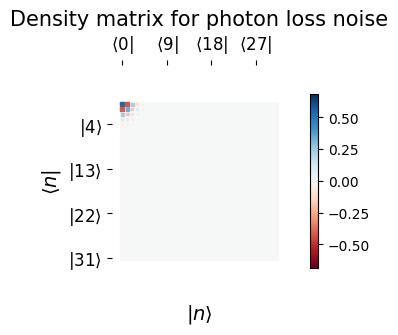

In [4]:
pl_noise = qst.data.photon_loss_noise(test_state, 1e3, 1, 0.5)           # Parameters chosen here such that the photon number is reduced by 50%

qst.plot_hinton(pl_noise, label='photon loss noise')
plt.show()

### Measurement noise

We first create the phase space grid for heterodyne detection:

In [5]:
data_dim = 32
alpha_grid = qst.phase_space_grid(-5, 5, -5, 5, data_dim, data_dim)

We now create heterodyne detection measurement data from the clean state:

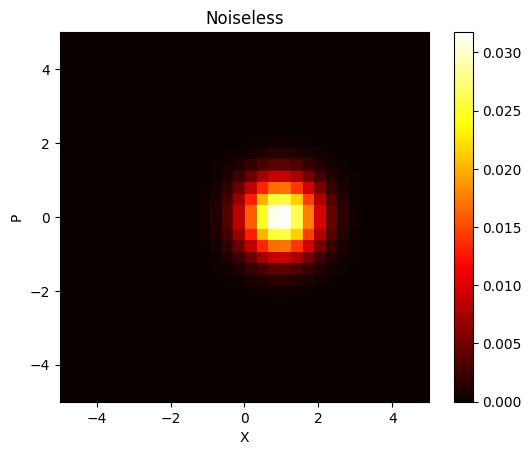

In [6]:
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', alpha_grid=alpha_grid)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
measurement_data = expectation_values/np.sum(expectation_values)                # Normalize to get a probability distribution

# Optional - simulate finite measurements
# measurement_data = qst.data.measure_shots(measurement_data, 10000)

plt.imshow(measurement_data.reshape(data_dim, data_dim), cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Noiseless')
plt.show()

Overlapping pulse mode mismatch, and uncertainty in the measurement of quadratures are simulated by noise the phase space grid itself:

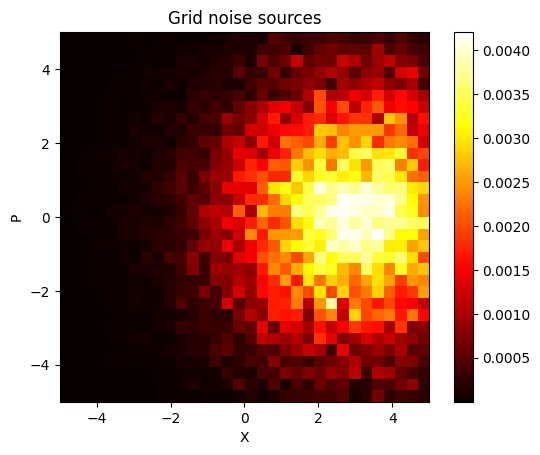

In [7]:
alpha_grid = qst.data.mode_mismatch_noise(alpha_grid, 0.1)
alpha_grid = qst.data.phase_error_noise(alpha_grid, 0.1)
alpha_grid = qst.data.displacement_error_noise(alpha_grid, 0.1)

measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', alpha_grid=alpha_grid)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
measurement_data = expectation_values/np.sum(expectation_values)                # Normalize to get a probability distribution

# Optional - simulate finite measurements
# measurement_data = qst.data.measure_shots(measurement_data, 10000)

plt.imshow(measurement_data.reshape(data_dim, data_dim), cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Grid noise sources')
plt.show()

Alternatively, systematic errors in phase space calibration can be simulated by affine transformations in the measured image:

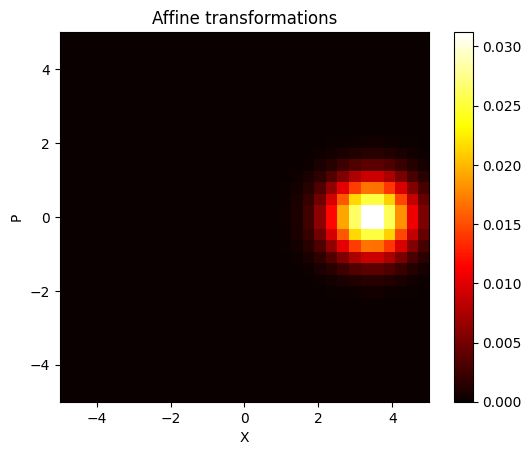

In [8]:
alpha_grid = qst.phase_space_grid(-5, 5, -5, 5, data_dim, data_dim)
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', alpha_grid=alpha_grid)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
measurement_data = expectation_values/np.sum(expectation_values)                # Normalize to get a probability distribution

affine_noise = qst.data.affine_transformation(measurement_data.reshape(data_dim, data_dim), theta=30, x=0.4, y=0.4)

# Optional - simulate finite measurements
# affine_noise = qst.data.measure_shots(affine_noise.reshape(1, data_dim**2), 10000)

plt.imshow(affine_noise.reshape(data_dim, data_dim), cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Affine transformations')
plt.show()

Additive Gaussian noise, sampled from the standard normal distribution, is used to simulate the discretisation of a continuous phase space, as well as finite measurement data (in place of `measure_shots()`):

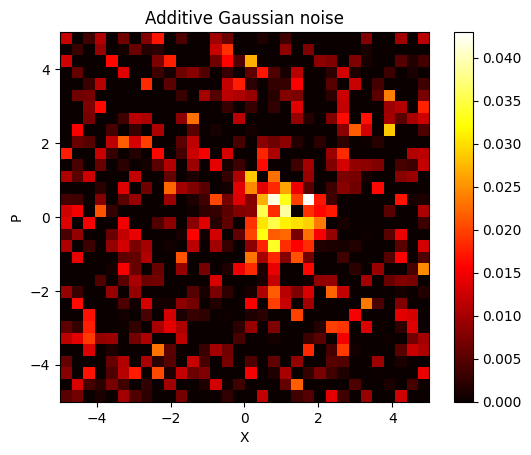

In [9]:
alpha_grid = qst.phase_space_grid(-5, 5, -5, 5, data_dim, data_dim)
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', alpha_grid=alpha_grid)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
measurement_data = expectation_values/np.sum(expectation_values)                # Normalize to get a probability distribution

additive_noise = qst.data.additive_gaussian_noise(measurement_data, 0.0, 0.01)

plt.imshow(additive_noise.reshape(data_dim, data_dim), cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Additive Gaussian noise')
plt.show()

### Data noise

Additional bosonic modes may arise from linear amplifiers in photodetectors, modeled using a Gaussian convolution:

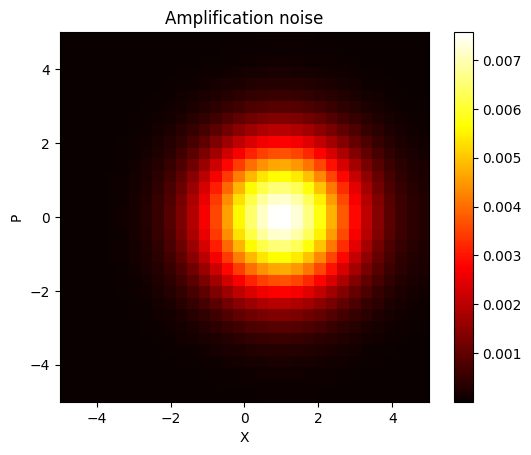

In [10]:
alpha_grid = qst.phase_space_grid(-5, 5, -5, 5, data_dim, data_dim)
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', alpha_grid=alpha_grid)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
measurement_data = expectation_values/np.sum(expectation_values)                # Normalize to get a probability distribution

# Optional - simulate finite measurements
# measurement_data = qst.data.measure_shots(measurement_data, 10000)

amp_noise = qst.data.amplification_noise(measurement_data.reshape(data_dim, data_dim), ntherm=4)

plt.imshow(amp_noise.reshape(data_dim, data_dim), cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Amplification noise')
plt.show()

Pixel over-saturation and non-operation are simulated using 'salt-and-pepper noise', where a proportion of pixel probabilities are fixed to 1 and 0:

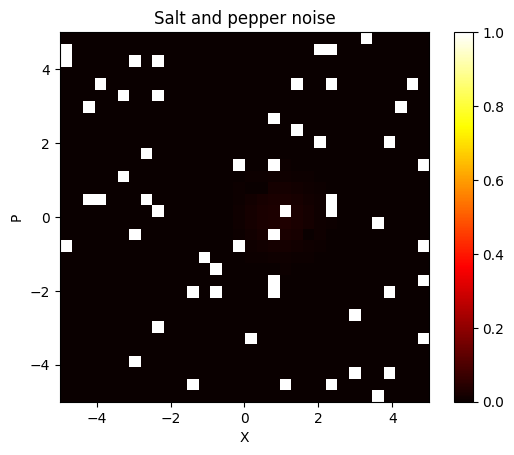

In [11]:
alpha_grid = qst.phase_space_grid(-5, 5, -5, 5, data_dim, data_dim)
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', alpha_grid=alpha_grid)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
measurement_data = expectation_values/np.sum(expectation_values)                # Normalize to get a probability distribution

# Optional - simulate finite measurements
# measurement_data = qst.data.measure_shots(measurement_data, 10000)

sp_noise = qst.data.salt_and_pepper_noise(measurement_data, pepper_p=0.05, salt_p=0.05)

plt.imshow(sp_noise.reshape(data_dim, data_dim), cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Salt and pepper noise')
plt.show()

### Combined noise

QSTToolkit provides `apply_measurement_noise()` which applies all measurement and data noise sources to a Husimi Q image at once:

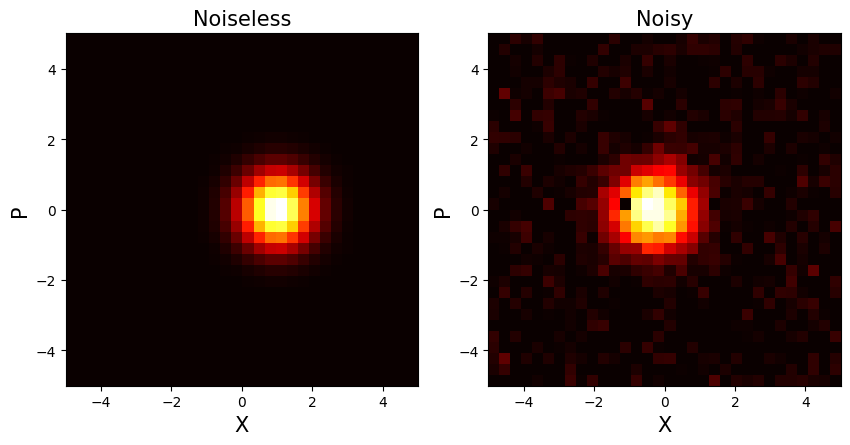

In [12]:
alpha_grid = qst.phase_space_grid(-5, 5, -5, 5, data_dim, data_dim)
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', alpha_grid=alpha_grid)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
measurement_data = expectation_values/np.sum(expectation_values)                # Normalize to get a probability distribution

noisy_data = qst.data.apply_measurement_noise(measurement_data.reshape(data_dim, data_dim),
                                              amplification_ntherm=1.0,
                                              affine_theta=20,
                                              affine_x=0.1,
                                              affine_y=0.1,
                                              additive_Gaussian_stddev=0.001,
                                              pepper_p=0.01,
                                              salt_p=0.0)

_, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(measurement_data.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5], origin='lower', cmap='hot')
axs[0].set_title('Noiseless', fontsize=15)
axs[0].set_xlabel('X', fontsize=15)
axs[0].set_ylabel('P', fontsize=15)

axs[1].imshow(noisy_data.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5], origin='lower', cmap='hot')
axs[1].set_title('Noisy', fontsize=15)
axs[1].set_xlabel('X', fontsize=15)
axs[1].set_ylabel('P', fontsize=15)

plt.show()

QSTToolkit provides `optical_state_dataset()` which produces the above dataset in one function, intended to be used as a standardised dataset for training models. All the implemented noise sources are applied to the generated data, with levels that can be adjusted in the arguments:

In [13]:
data = qst.data.optical_state_dataset(dim=32,
                                      data_dim=32,
                                      state_numbers=[1000, 1000, 1000, 1000, 1000, 1000, 0, 0],       # Large numbers of GKP states take an intractable amount of time to produce, and are difficult to produce practically
                                      mixed_state_noise_level = 0.2,
                                      amplification_ntherm = 2.0,
                                      affine_theta = 20.0,
                                      affine_x = 0.1,
                                      affine_y = 0.1,
                                      additive_Gaussian_stddev = 0.001,
                                      pepper_p = 0.01,
                                      salt_p = 0.0)

Fock states generated
Coherent states generated
Thermal states generated


c:\Users\gwfit\OneDrive\Documents\Durham University Physics\Level 4\MPhys Project - Deep Learning Quantum Tomography\Code\qsttoolkit-private\qsttoolkit\data\state_batches.py:164: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Num states generated
Binomial states generated
Cat states generated
GKP states generated
Random states generated
DataFrames initialized


c:\Users\gwfit\OneDrive\Documents\Durham University Physics\Level 4\MPhys Project - Deep Learning Quantum Tomography\Code\qsttoolkit-private\qsttoolkit\data\state_batches.py:354: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
C:\Users\gwfit\AppData\Local\Temp\ipykernel_26460\956872841.py:1: FutureWarning: The column 'Husimi-Q' will be renamed to 'Husimi_Q' in the next major update.
  data = qst.data.optical_state_dataset(dim=32,


Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
GKP data generated
Random data generated
Dataset generated


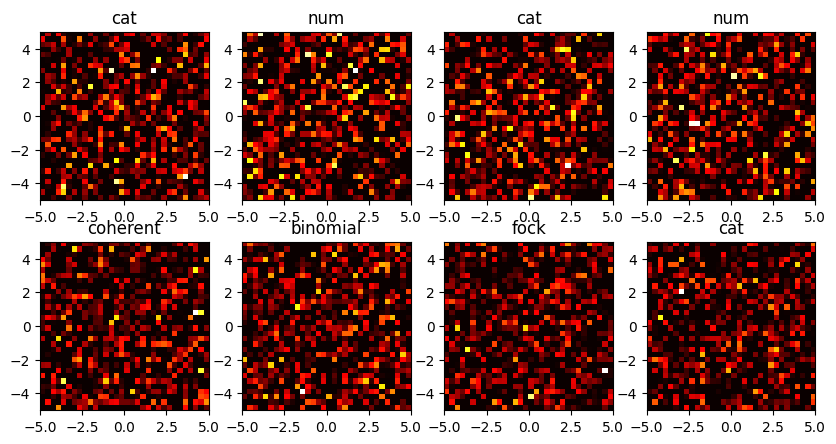

In [14]:
_, axs = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data['Husimi-Q_function'][i], extent=[-5, 5, -5, 5], cmap='hot')
    ax.set_title(data['label'][i])